In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import urllib
import json
import pandas as pd
import matplotlib.pyplot as plt
from MesoPy import Meso
import datetime as dt
from datetime import datetime
import numpy as np
import pytz
import math
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib as mpl
import matplotlib.dates as dates
%matplotlib inline

In [3]:
def FWI(wspd,RH,Temp):# U and T in imperial units and RH in percent
    T = (Temp* (9/5)) + 32
    U = wspd * 2.23694
    for  i in range(len(RH)):
        if U[i]>= 30:
            fwi = 100
        else:    
        
            if RH[i] < 10:
                m = 0.03229 + (0.281073*RH[i])-(0.000578*RH[i]*T)
            elif RH[i] >= 11 and RH[i] <= 50:
                m = 2.2749+(0.160107*RH[i])-(0.014784*T)
            elif RH[i] > 50:
                m = 21.0606 + (0.005565*(RH[i]**2))-(0.00035*RH[i]*T)-(0.483199*RH[i])
        mx = 30
        eta = 1-(2*(m/mx))+(1.5*((m/mx)**2))-(.5*((m/mx)**3))
        fwi = (eta*((np.sqrt(1+((U)**2))))/0.3002)
    return fwi

In [4]:
def daylight(lat,jdate ):
    phi = lat * 0.01745
    decl = 0.41008*np.sin((jdate-82)*0.01745)
    return 24*((1-np.arccos(np.tan(phi))*np.tan(decl))/3.1416)

def EMC(RH, T):
    Temp = ((T* (9/5)) + 32)
    if RH < 10:
        m = 0.03229 + (0.281073)-(0.000578*RH*Temp)
    elif RH >= 10 and RH < 50:
        m = 2.2749+(0.160107*RH)-(0.014784*Temp)
    else:
        m = 21.0606 + (0.005565*(RH**2))-(0.00035*RH*Temp)-(0.483199*RH)
    return m 

def emcbar(daylight, emcmin, emcmax):
    return ((daylight*emcmin+(24-daylight)*emcmax)/24)

def bndryh(precip, emcbar): #24 hour accum precip
    return ((24-precip)*emcbar+precip*(.5*precip+41))/24

def MC100(YMC100, bndryh):
    return YMC100+(bndryh-YMC100)*(1-0.87*np.exp(-0.24))    

In [5]:
def HDW(T, RH, U):
    es = mpcalc.saturation_vapor_pressure(T*units.degC)
    e = (RH*np.array(es))/100
    vpd = np.array(es)-e
    return vpd * U

In [6]:
def precip_dur(precip):
    precip_dur_ar = np.zeros_like(precip)
    for i in range(1,len(precip)):
        if precip[i]-precip[i-1] > 0:
            precip_dur_ar[i-1] = 1
        else:
            precip_dur_ar[i-1]=0
    return np.sum(precip_dur_ar)

In [7]:
jbc = pd.read_csv('C:/Users/Matthew/Documents/SJSUsummer2018/fuels/Jargo_Climo.txt',delimiter=r"\s+", skiprows = 2, names = ('DATE','Time','F100','FM10','FMW','FFWI','ERC','BI','IC' ))
jbc.index = pd.DatetimeIndex(pd.to_datetime( jbc.DATE +' '+ jbc.Time, format = '%m/%d/%Y %H:%M'))
y_jbc = jbc.groupby([jbc.index.month,jbc.index.day]).mean()
max_jbc = jbc.groupby([jbc.index.month,jbc.index.day]).max()
min_jbc = jbc.groupby([jbc.index.month,jbc.index.day]).min()

In [69]:
from datetime import datetime, timedelta

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

In [70]:
m = Meso(token = "b53008fafc7c47fca757eb387d61bded")
pst = pytz.timezone('US/Pacific')
StartDate = dt.datetime(2018, 8, 1, 13)
EndDate   = dt.datetime(2018, 11, 15, 13)
dts = [dt.strftime('%Y-%m-%d T%H:%M Z') for dt in 
       datetime_range(StartDate, EndDate,  timedelta(days=1))]
dtt = pd.to_datetime(dts)
stid= {'CICC1', 'JBGC1','PG131',  'CDEC1'}
for i, value in enumerate(stid,1):
    exec(f"d{i}= m.timeseries(stid=value,start = StartDate.strftime('%Y%m%d%H%M'),end =EndDate.strftime('%Y%m%d%H%M'))")

MesoPyError: 'Could not connect to the API. This could be because you have no internet connection, a parameter was input incorrectly, or the API is currently down. Please try again.'

In [ ]:
YMC100_0 = 15 # found at https://famit.nwcg.gov/sites/default/files/Appx_F_Detailed_NFDRS_Inputs.pdf
julianday = (StartDate.timetuple().tm_yday)
julianday

In [103]:
for i, value in enumerate(stid,1):
    exec(f"ob{i} = d{i}['STATION'][0]")
    exec(f"timestamps{i} = (ob{i}['OBSERVATIONS']['date_time'])")
    exec(f"temp{i} = ob{i}['OBSERVATIONS']['air_temp_set_1']")
    exec(f"wspd{i} = ob{i}['OBSERVATIONS']['wind_speed_set_1']")
    exec(f"wgst{i} = ob{i}['OBSERVATIONS']['wind_gust_set_1']")
    exec(f"wdir{i} = ob{i}['OBSERVATIONS']['wind_direction_set_1']")
    exec(f"rh{i} = ob{i}['OBSERVATIONS']['relative_humidity_set_1']")
    exec(f"stid{i} = ob{i}['STID']")
    exec(f"LAT{i} = ob{i}['LATITUDE']")
    exec(f"LON{i} = ob{i}['LONGITUDE']")
    exec(f"dates{i} = (datetime.strptime(ts, '%Y-%m-%dT%H:%M:%SZ') for ts in timestamps{i})")
    exec(f"date_strings{i} = [datetime.strftime(d, '%Y-%m-%dT%H:%M:%SZ') for d in dates{i}]")
    exec(f"df{value} = pd.DataFrame()")
    exec(f"df{value}['temp']=temp{i}")
    exec(f"df{value}['wgst']=wgst{i}")
    exec(f"df{value}['wspd']=wspd{i}")
    exec(f"df{value}['wdir']=wdir{i}")
    exec(f"df{value}['rh']=rh{i}")
    exec(f"df{value}['stid']=stid{i}")
    exec(f"df{value}['LAT']=LAT{i}")
    exec(f"df{value}['LON']=LON{i}")
    exec(f"df{value}['time'] = date_strings{i}")
    exec(f"df{value}.index = pd.DatetimeIndex(pd.to_datetime( df{value}.time, format = '%Y-%m-%dT%H:%M:%SZ')).tz_localize('UTC').tz_convert('US/Pacific')")
    try:
        exec(f"precip_{i} = ob{i}['OBSERVATIONS']['precip_accum_set_1']")
        exec(f"df{value}['24p']=precip_{i}")
    except:
        pass

In [159]:
mc100 = np.zeros_like(np.array(dts), dtype = float)
julianday = (StartDate.timetuple().tm_yday)
jdat = np.zeros_like(np.array(dts), dtype = float)
for i in range(0,len(dts)):
    jdat[i]=julianday + i
for i in range(len(dts)):
    print(i)
    try:
        df = dfJBGC1.loc['2018-'+str(dts[i][5:7])+'-'+str(dts[i][8:10])+' 13:13:00-07:00':'2018-'+str(dts[i+1][5:7])+'-'+str(dts[i+1][8:10])+' 13:13:00-07:00']
    except:
        df = dfJBGC1.loc['2018-'+str(dts[i][5:7])+'-'+str(dts[i][8:10])+' 13:13:00-08:00':'2018-'+str(dts[i+1][5:7])+'-'+str(dts[i+1][8:10])+' 13:13:00-08:00']
    lat_stn = np.array(dfJBGC1.LAT[0], dtype = float)
    T = np.array(df['temp'])
    t_max = np.max(T)
    t_min = np.min(T)
    rh = np.array(df['rh'])
    rh_max = np.max(rh)
    rh_min = np.min(rh)
    precip = np.array(df['24p'])
    dl = daylight(lat_stn, jdat[i])
    emcmin = EMC(rh_min,t_max)
    emcmax = EMC(rh_max,t_min)
    emc_bar = emcbar(dl, emcmin,emcmax)
    precipdur = precip_dur(precip)
    bnd = bndryh(precipdur,emc_bar)
    if i == 0:
        mc100[i] = MC100(YMC100_0, bnd)
    else: 
        mc100[i]=MC100(mc100[i-1], bnd)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102


ValueError: zero-size array to reduction operation maximum which has no identity

In [160]:
mc1002 = np.zeros_like(np.array(dts), dtype = float)
julianday = (StartDate.timetuple().tm_yday)
jdat = np.zeros_like(np.array(dts), dtype = float)
for i in range(0,len(dts)):
    jdat[i]=julianday + i
for i in range(len(dts)):
    print(i)
    try:
        df = dfCICC1.loc['2018-'+str(dts[i][5:7])+'-'+str(dts[i][8:10])+' 12:54:00-07:00':'2018-'+str(dts[i+1][5:7])+'-'+str(dts[i+1][8:10])+' 12:54:00-07:00']
    except:
        df = dfCICC1.loc['2018-'+str(dts[i][5:7])+'-'+str(dts[i][8:10])+' 12:54:00-08:00':'2018-'+str(dts[i+1][5:7])+'-'+str(dts[i+1][8:10])+' 12:54:00-08:00']
    df = df.dropna()
    lat_stn = np.array(dfCICC1.LAT[0], dtype = float)
    T = np.array(df['temp'])
    t_max = np.max(T)
    t_min = np.min(T)
    rh = np.array(df['rh'])
    rh_max = np.max(rh)
    rh_min = np.min(rh)
    precip = np.array(df['24p'])
    dl = daylight(lat_stn, jdat[i])
    emcmin = EMC(rh_min,t_max)
    emcmax = EMC(rh_max,t_min)
    emc_bar = emcbar(dl, emcmin,emcmax)
    precipdur = precip_dur(precip)
    bnd = bndryh(precipdur,emc_bar)
    if i == 0:
        mc1002[i] = MC100(YMC100_0, bnd)
    else: 
        mc1002[i]=MC100(mc1002[i-1], bnd)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105


IndexError: list index out of range

In [161]:
StartDate1 = dt.datetime(2018, 9, 27, 13)
EndDate1   = dt.datetime(2018, 11, 15,13)
dts1 = [dt.strftime('%Y-%m-%d T%H:%M Z') for dt in 
       datetime_range(StartDate1, EndDate1,  timedelta(days=1))]
dtt1 = pd.to_datetime(dts1)
mc1003 = np.zeros_like(np.array(dts1), dtype = float)
julianday = (StartDate.timetuple().tm_yday)
jdat = np.zeros_like(np.array(dts), dtype = float)
for i in range(0,len(dts1)):
    jdat[i]=julianday + i
for i in range(len(dts1)):
    print(i)
    try:
        df = dfTR145.loc['2018-'+str(dts1[i][5:7])+'-'+str(dts1[i][8:10])+' 12:47:00-07:00':'2018-'+str(dts1[i+1][5:7])+'-'+str(dts1[i+1][8:10])+' 12:47:00-07:00']
    except:
        df = dfTR145.loc['2018-'+str(dts1[i][5:7])+'-'+str(dts1[i][8:10])+' 12:47:00-08:00':'2018-'+str(dts1[i+1][5:7])+'-'+str(dts1[i+1][8:10])+' 12:47:00-08:00']
    lat_stn = np.array(dfTR145.LAT[0], dtype = float)
    T = np.array(df['temp'])
    t_max = np.max(T)
    t_min = np.min(T)
    rh = np.array(df['rh'])
    rh_max = np.max(rh)
    rh_min = np.min(rh)
    precip = np.array(df['24p'])
    dl = daylight(lat_stn, jdat[i])
    emcmin = EMC(rh_min,t_max)
    emcmax = EMC(rh_max,t_min)
    emc_bar = emcbar(dl, emcmin,emcmax)
    precipdur = precip_dur(precip)
    bnd = bndryh(precipdur,emc_bar)
    if i == 0:
        mc1003[i] = MC100(YMC100_0, bnd)
    else: 
        mc1003[i]=MC100(mc1003[i-1], bnd)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


IndexError: list index out of range

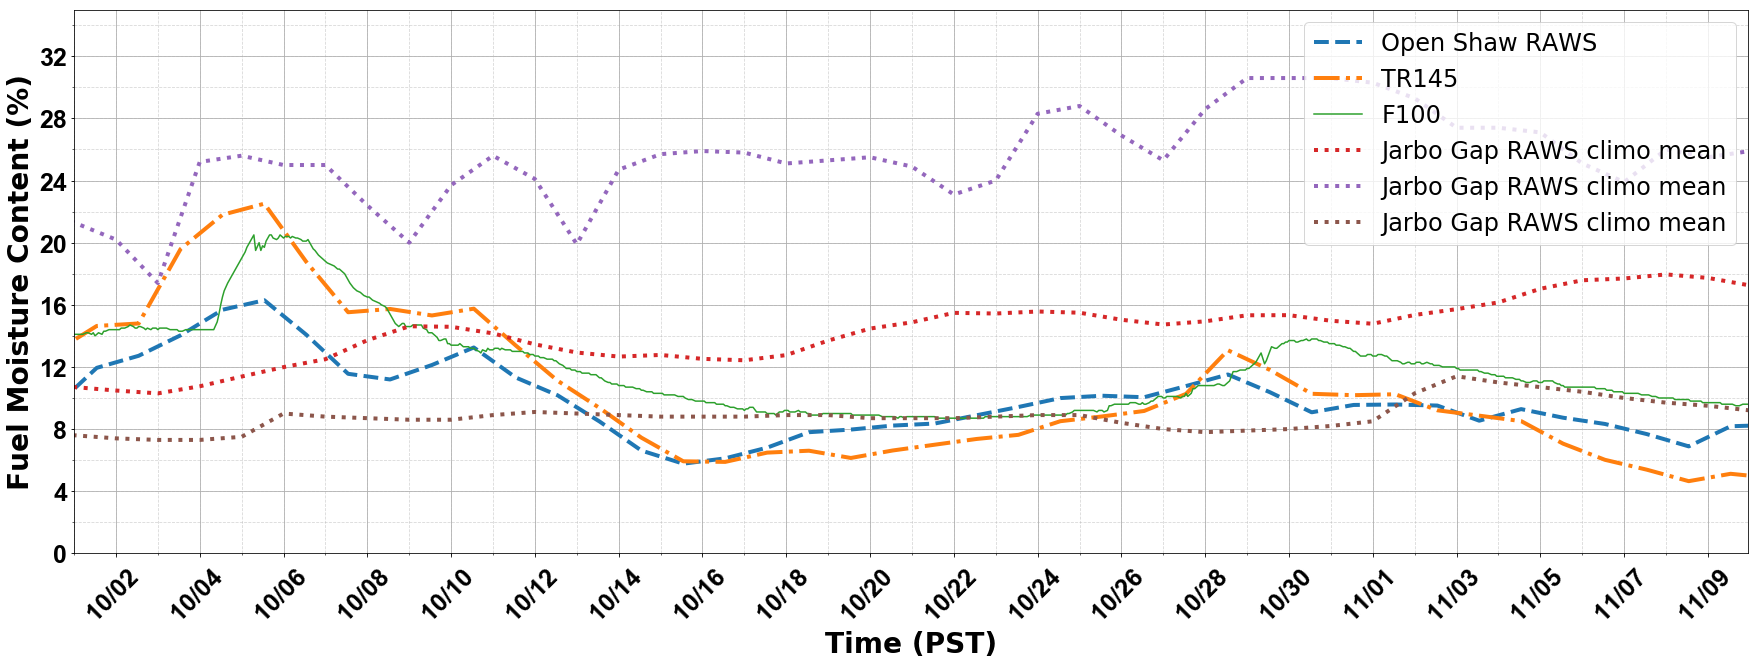

In [164]:
fig = plt.figure(figsize = (30,10))
ax = plt.subplot(111)
#ax.plot(dtt, mc100, label = 'Jarbo Gap RAWS', linewidth = 4)
ax.plot(dtt, mc1002, label = 'Open Shaw RAWS', linewidth = 4, ls = '--')
ax.plot(dtt1, mc1003, label = 'TR145', linewidth = 4, ls = '-.')
ax.plot(jbc.index, jbc['F100'])
ax.plot(dttts, y_jbc['F100'].values[:-4], linewidth = 4, ls = ':', label = 'Jarbo Gap RAWS climo mean')
ax.plot(dttts, max_jbc['F100'].values[4:], linewidth = 4, ls = ':', label = 'Jarbo Gap RAWS climo mean')
ax.plot(dttts, min_jbc['F100'].values[4:], linewidth = 4, ls = ':', label = 'Jarbo Gap RAWS climo mean')
plt.gca().set_xlim(pd.Timestamp('10/01/2018 00:00:00'), pd.Timestamp('11/09/2018 23:00:00'))
ax.xaxis.set_major_locator(dates.DayLocator(interval=2))
ax.xaxis.set_minor_locator(dates.DayLocator(interval=1))# every day
ax.xaxis.set_major_formatter(dates.DateFormatter('%m/%d '))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base = 4))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(base = 2))
ax.grid(which= 'minor', ls = '--', alpha = .5)
#ax.set_title('NFDR 100 Hour Fuel Moisture', fontsize = 30)
ax.set_xlabel('Time (PST)', fontsize = 28, fontweight = 'bold')
ax.set_ylabel('Fuel Moisture Content (%)', fontsize = 28, fontweight = 'bold')
ax.legend(fontsize = 24)
ax.set_ylim(0,35)
plt.xticks(rotation=45)
ax.grid()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(25)
    label.set_fontweight('bold');
#plt.savefig('100fmc.png', dpi=fig.dpi, bbox_inches = 'tight')


In [ ]:
jg_hdw = HDW(np.array(dfJBGC1.temp), dfJBGC1.rh, dfJBGC1.wspd)
cc_hdw = HDW(np.array(dfCICC1.temp), dfCICC1.rh, dfCICC1.wspd)

jg_fwi = FWI(dfJBGC1.wspd, dfJBGC1.rh,dfJBGC1.temp )
cc_fwi = FWI(dfCICC1.wspd, dfCICC1.rh,dfCICC1.temp )
tr_fwi = FWI(dfTR145.wspd, dfTR145.rh,dfTR145.temp )

NameError: name 'jg_hdw' is not defined

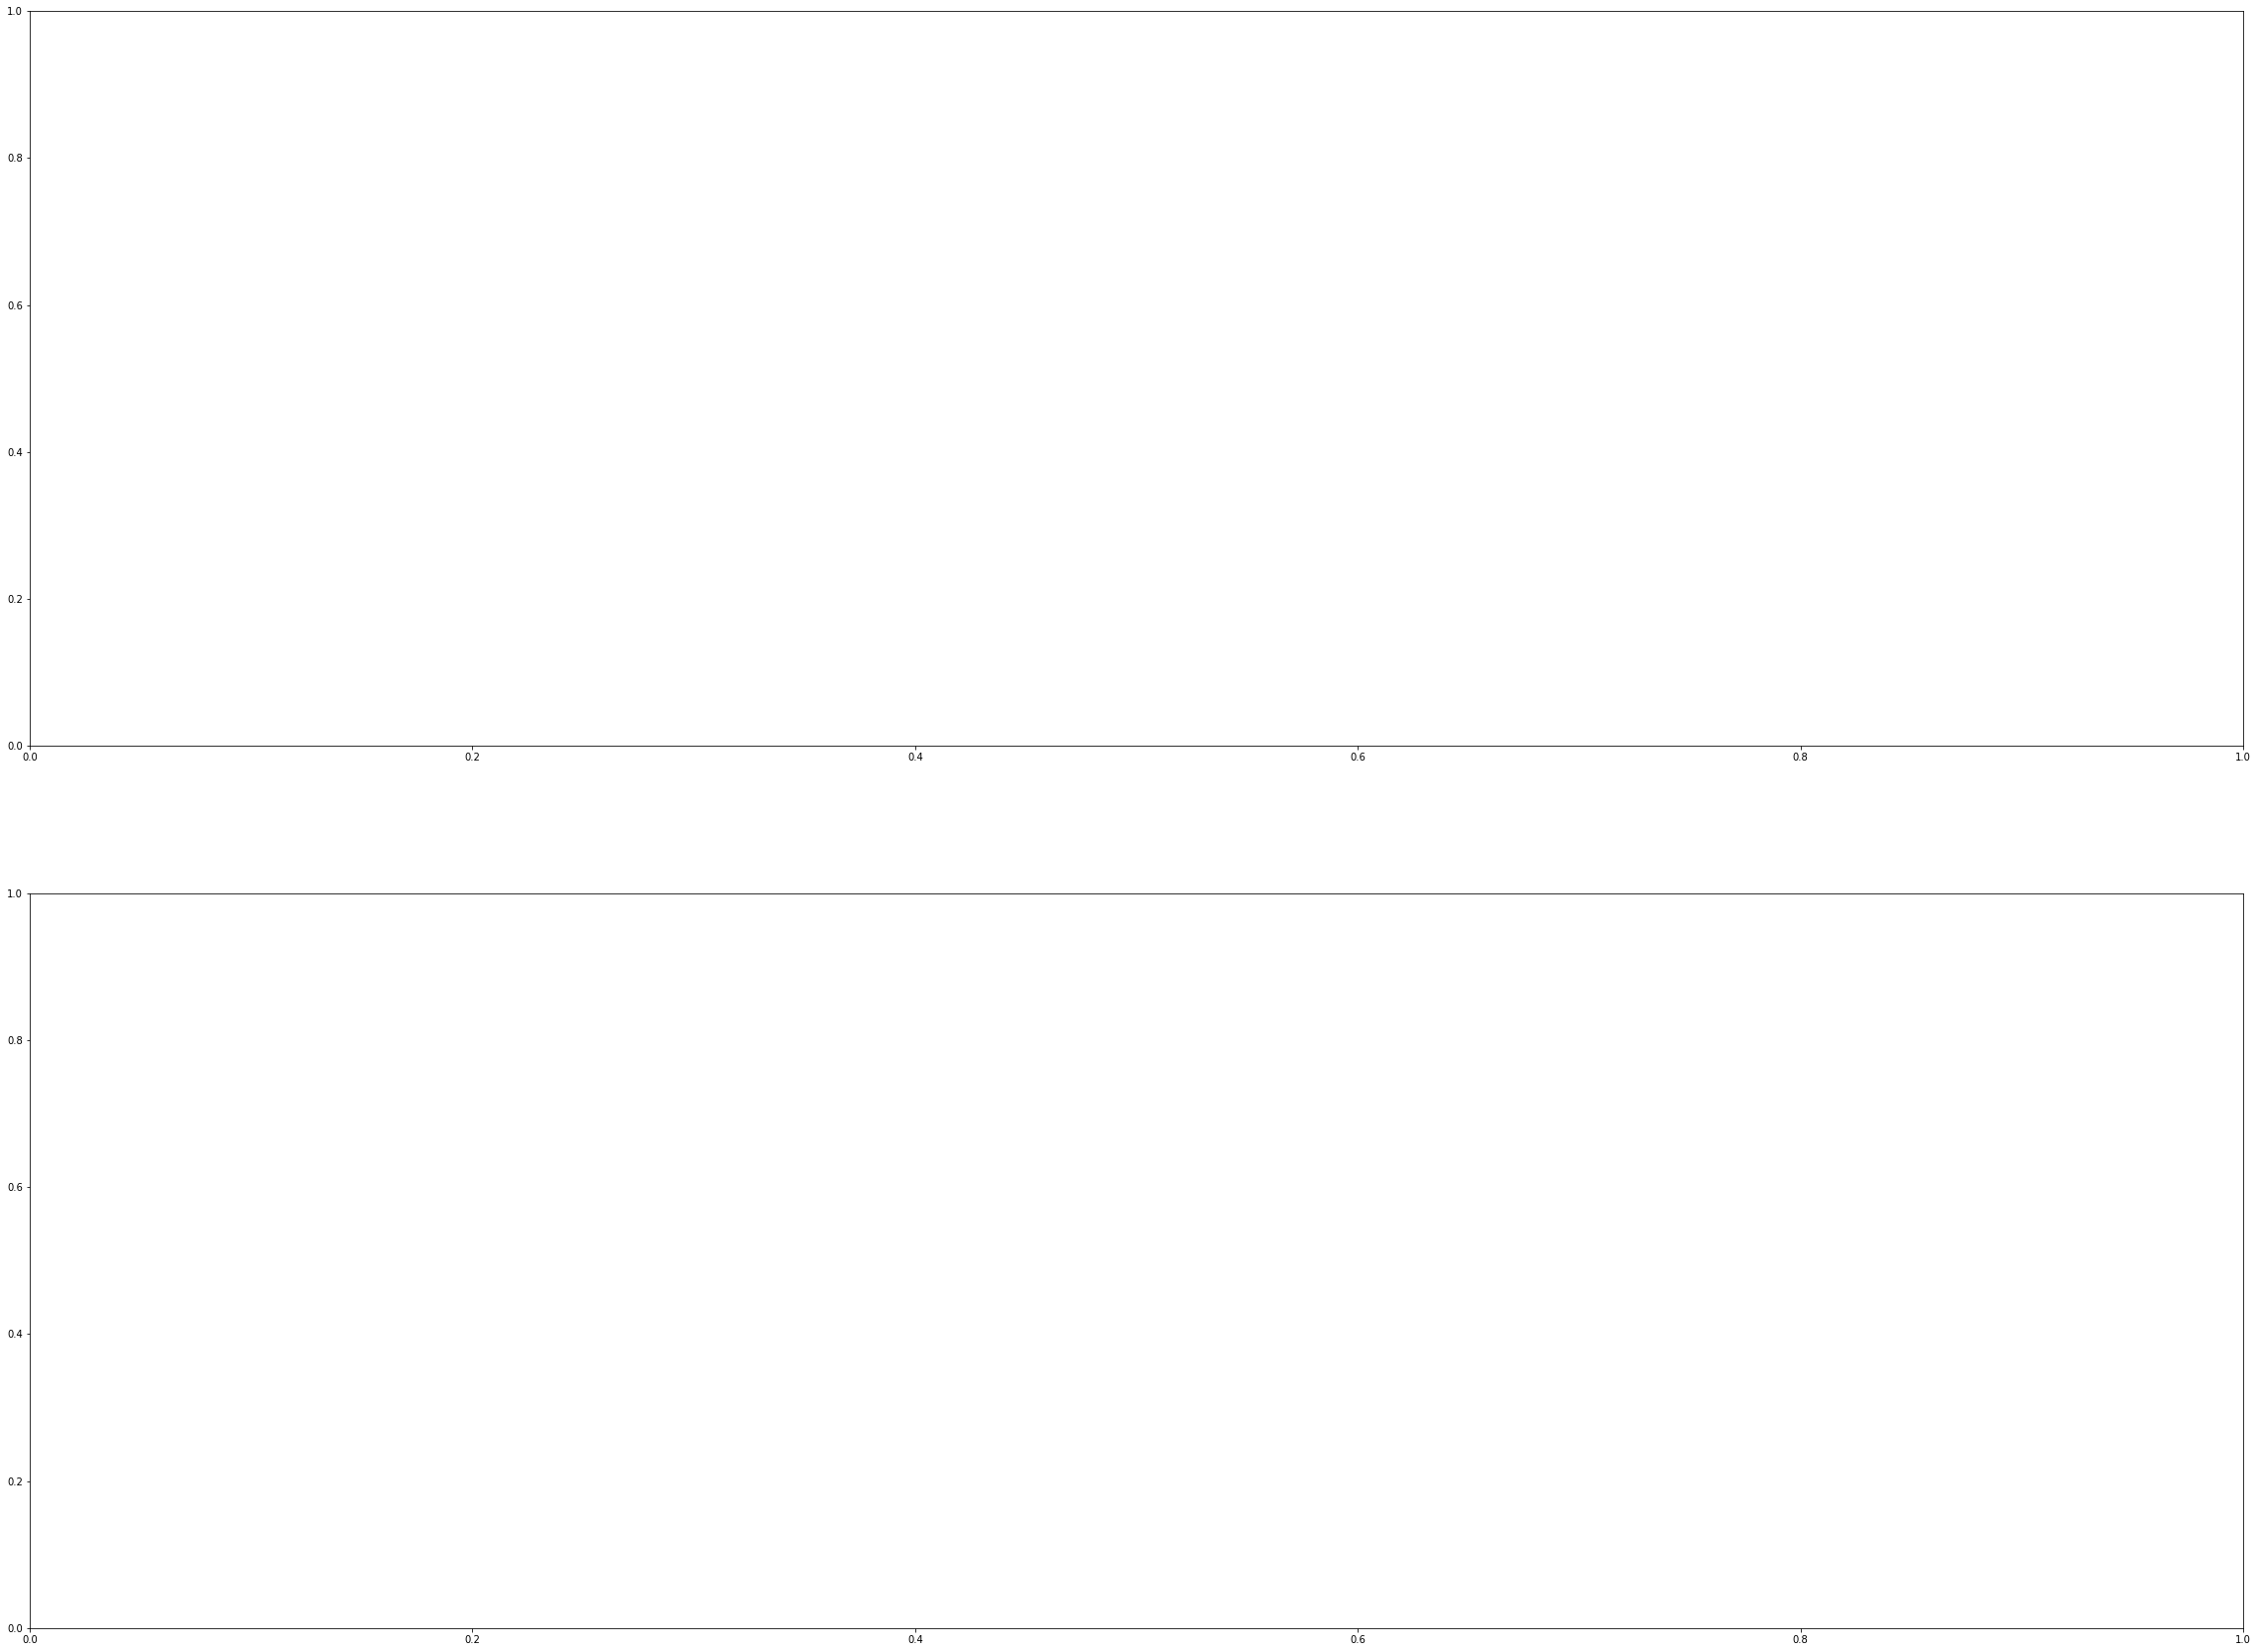

In [90]:
fig = plt.figure(figsize = (40,30))
ax = plt.subplot(211)
ax2 = plt.subplot(212)
ax.plot(jg_hdw, label = 'Jarbo Gap HDW', linewidth = 2, color = 'tab:red')
ax.plot(cc_hdw, label = 'Open Shaw HDW', linewidth = 2, color = 'tab:green')
ax.set_xlim(pd.Timestamp('10/15/2018 00:00:00'), pd.Timestamp('11/09/2018 23:00:00'))
ax.xaxis.set_major_locator(dates.DayLocator(interval=1))    # every day
ax.xaxis.set_major_formatter(dates.DateFormatter('%m/%d \n %Hz'));
ax.set_title('Hot Dry Windy Fire Weather Index', fontsize = 30)
ax.set_xlabel('Time (UTC)', fontsize = 25)
ax.set_ylabel('HDW index', fontsize = 25)
ax.legend(fontsize = 'xx-large')
#ax.set_ylim(0,15)
ax.grid()

ax2.plot(jg_fwi, label = 'Jargo Gap FWI', color = 'tab:red', linewidth = 2)
ax2.plot(cc_fwi, label = 'Open Shaw FWI' , color = 'tab:green', linewidth = 2)

ax2.set_xlim(pd.Timestamp('10/15/2018 00:00:00'), pd.Timestamp('11/09/2018 23:00:00'))
ax2.xaxis.set_major_locator(dates.DayLocator(interval=1))    # every day
ax2.xaxis.set_major_formatter(dates.DateFormatter('%m/%d \n %H'));
ax2.set_title('Foseburg Fire Weather Index', fontsize = 30)
ax2.set_xlabel('Time (PST)', fontsize = 25)
ax2.set_ylabel('FWI index', fontsize = 25)
ax2.legend(loc = 2,fontsize = 'xx-large')
#ax.set_ylim(0,15)
ax2.grid()

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(18);
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(18);
#plt.savefig('hdw_fwi.png', dpi=fig.dpi)    

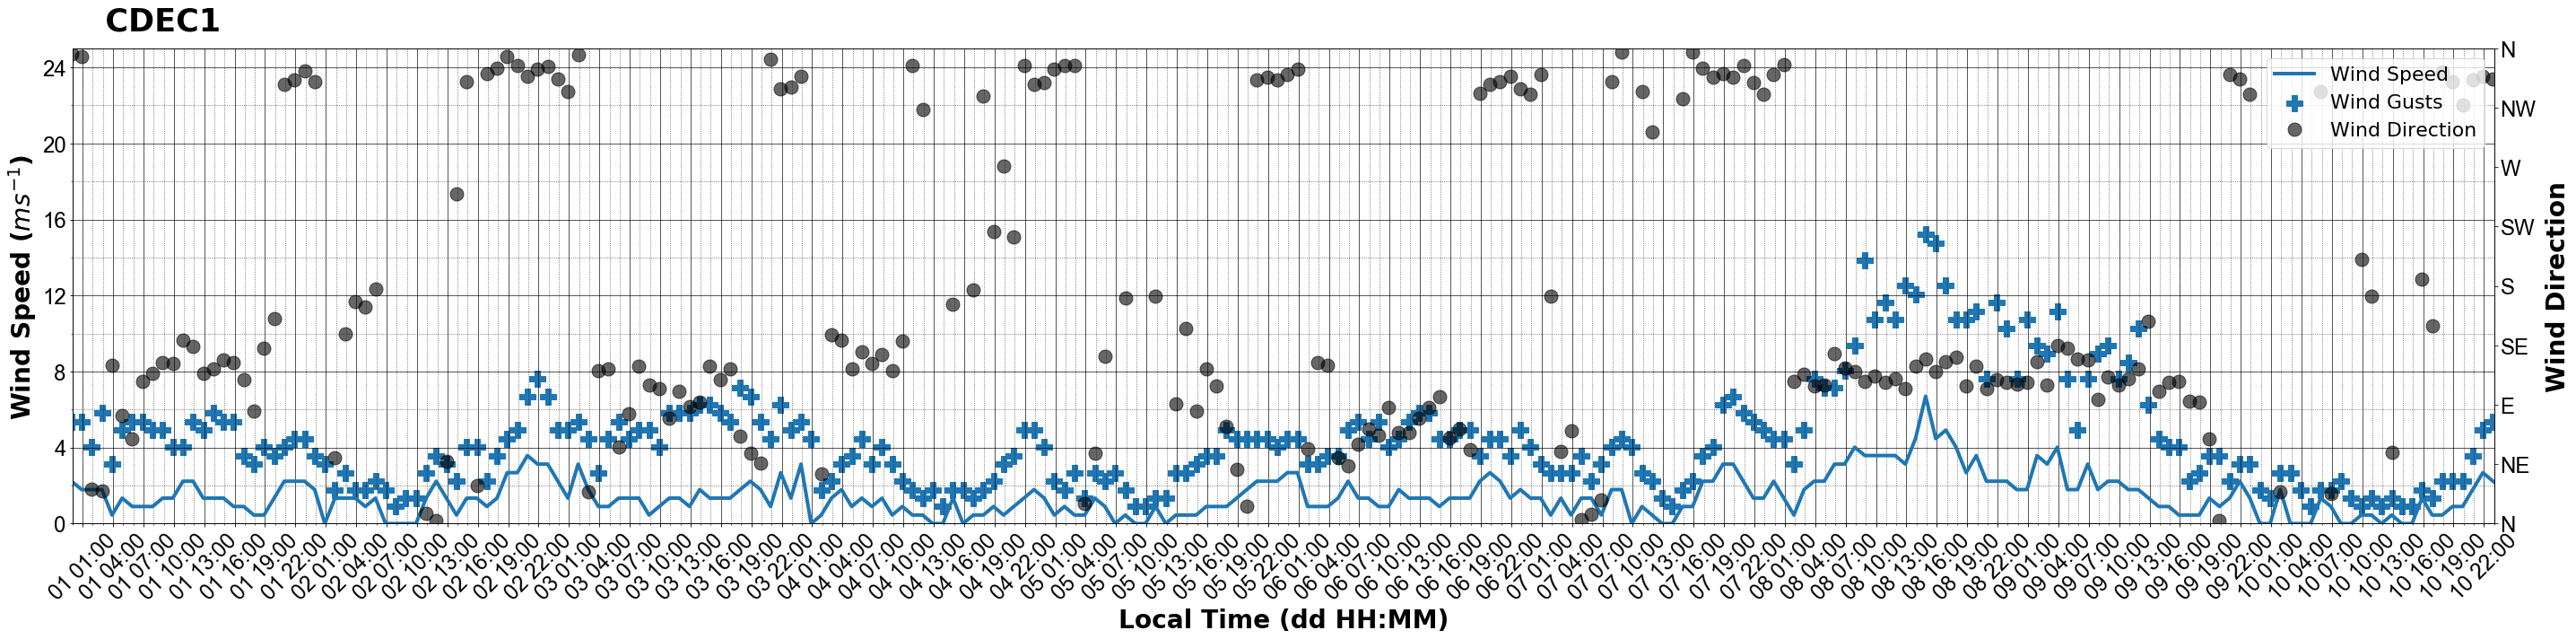

In [92]:
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']
fig= plt.figure(figsize = (40,10))
#fig.suptitle('Jarbo Gap RAWS', fontsize = 40)
"""ax = fig.add_subplot(211)
ax.plot(dfPG131.temp, color = 'red', label = 'Air Temperature', linewidth = 4)
ax.set_ylabel('Temp ($\degree$C)', fontsize = 30, fontweight = 'bold')
ax.set_xlabel('Time (Day/Hour)', fontsize = 30, fontweight = 'bold')
ax.set_ylim(5,30)

###
ax1 = ax.twinx()
ax1.plot(dfPG131.rh, linestyle = '-', label = 'RH', linewidth = 4)
ax1.set_ylabel('RH (%)', fontsize = 30, fontweight = 'bold')
ax1.set_ylim(0,100)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=0, fontsize = 30)


for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20);
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    


plt.gca().set_xlim(pd.Timestamp('11/07/2018 00:00:00'), pd.Timestamp('11/10/2018 23:00:00'))
#ax.xaxis.set_major_locator(dates.DayLocator(interval=1))# every day
ax.xaxis.set_major_locator(dates.HourLocator(interval=3))# every day
ax.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n%H'))

ax.grid()
ax.grid(which = 'minor', alpha = .7, ls = ':')
ax.set_title('Temperature and RH', fontsize = 35, fontweight = 'bold')"""
####################################################################################################

ax2 = fig.add_subplot(111)
ax2.plot(dfCDEC1.wspd, linewidth = 4, label = 'Wind Speed')
ax2.scatter(dfCDEC1.index, dfCDEC1.wgst, marker = 'P', s =350, label = 'Wind Gusts')
ax2.set_ylabel('Wind Speed ($ms^{-1}$)', fontsize = 28, fontweight = 'bold')
ax2.set_xlabel('Local Time (dd HH:MM)', fontsize = 28, fontweight = 'bold')
ax2.set_ylim(0,25)
ax2.grid(color = 'k', alpha = .7)
plt.xticks(rotation=45)
ax3= ax2.twinx()
ax3.plot(dfCDEC1.wdir, 'k.', markersize = 30, alpha = .6, label = 'Wind Direction')
ax3.set_ylim(0,360)
ax3.set_ylabel('Wind Direction', fontsize = 28, fontweight = 'bold', labelpad = 10)
ax3.set_yticklabels(["",'N',"NE", "E", "SE", "S", "SW", "W", "NW", "N"])
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + labels2, loc=1, fontsize = 22)


for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(24);
for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(24)
    


plt.gca().set_xlim(pd.Timestamp('11/01/2018 00:00:00'), pd.Timestamp('11/10/2018 23:00:00'))
#ax2.xaxis.set_major_locator(dates.DayLocator(interval=1))
ticks = ax2.xaxis.set_major_locator(dates.HourLocator(interval=3))
ax2.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base = 4))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(base = 2))
ax2.xaxis.set_major_formatter(dates.DateFormatter('%d %H:%M'))
ax3.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=45.0))
plt.xticks(rotation=30)
ax2.grid(which = 'minor',color = 'k', alpha = .7, ls = ':')
ax2.set_title('   CDEC1',loc = 'left', fontsize = 35, fontweight = 'bold', pad = 20.5)
plt.tight_layout()
#plt.savefig('jg_raws.png', dpi=fig.dpi)    

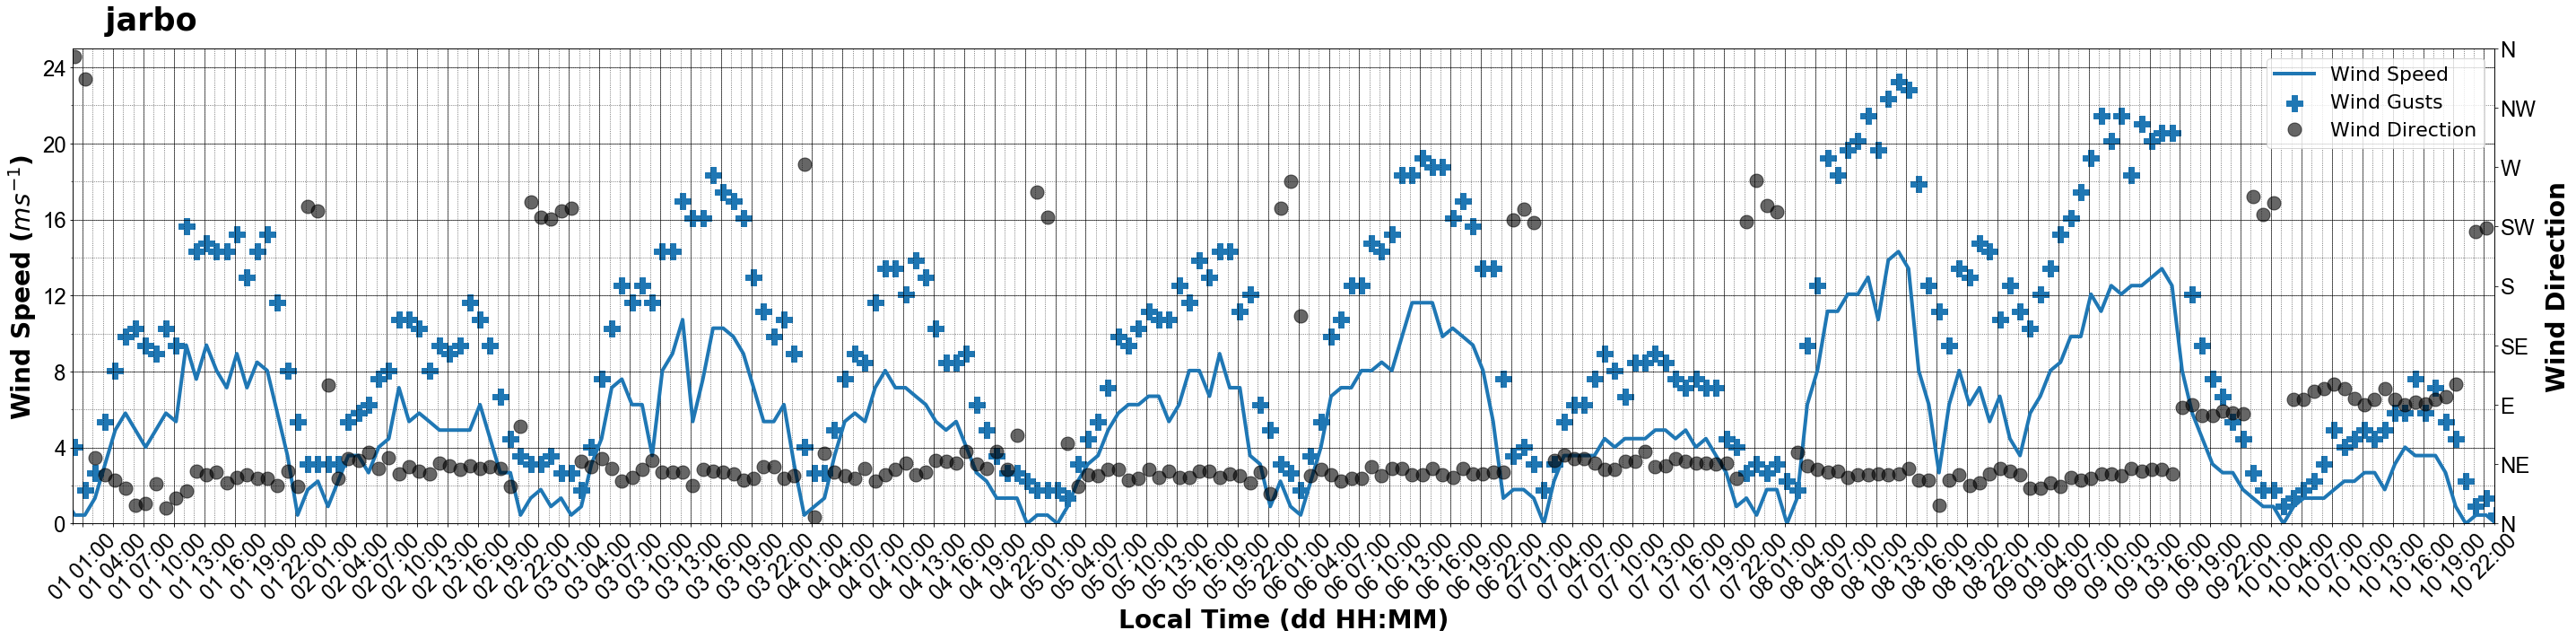

In [39]:
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']
fig= plt.figure(figsize = (40,10))
#fig.suptitle('Jarbo Gap RAWS', fontsize = 40)
"""ax = fig.add_subplot(211)
ax.plot(dfPG131.temp, color = 'red', label = 'Air Temperature', linewidth = 4)
ax.set_ylabel('Temp ($\degree$C)', fontsize = 30, fontweight = 'bold')
ax.set_xlabel('Time (Day/Hour)', fontsize = 30, fontweight = 'bold')
ax.set_ylim(5,30)

###
ax1 = ax.twinx()
ax1.plot(dfPG131.rh, linestyle = '-', label = 'RH', linewidth = 4)
ax1.set_ylabel('RH (%)', fontsize = 30, fontweight = 'bold')
ax1.set_ylim(0,100)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=0, fontsize = 30)


for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20);
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    


plt.gca().set_xlim(pd.Timestamp('11/07/2018 00:00:00'), pd.Timestamp('11/10/2018 23:00:00'))
#ax.xaxis.set_major_locator(dates.DayLocator(interval=1))# every day
ax.xaxis.set_major_locator(dates.HourLocator(interval=3))# every day
ax.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n%H'))

ax.grid()
ax.grid(which = 'minor', alpha = .7, ls = ':')
ax.set_title('Temperature and RH', fontsize = 35, fontweight = 'bold')"""
####################################################################################################

ax2 = fig.add_subplot(111)
ax2.plot(dfJBGC1.wspd, linewidth = 4, label = 'Wind Speed')
ax2.scatter(dfJBGC1.index, dfJBGC1.wgst, marker = 'P', s =350, label = 'Wind Gusts')
ax2.set_ylabel('Wind Speed ($ms^{-1}$)', fontsize = 28, fontweight = 'bold')
ax2.set_xlabel('Local Time (dd HH:MM)', fontsize = 28, fontweight = 'bold')
ax2.set_ylim(0,25)
ax2.grid(color = 'k', alpha = .7)
plt.xticks(rotation=45)
ax3= ax2.twinx()
ax3.plot(dfJBGC1.wdir, 'k.', markersize = 30, alpha = .6, label = 'Wind Direction')
ax3.set_ylim(0,360)
ax3.set_ylabel('Wind Direction', fontsize = 28, fontweight = 'bold', labelpad = 10)
ax3.set_yticklabels(["",'N',"NE", "E", "SE", "S", "SW", "W", "NW", "N"])
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + labels2, loc=1, fontsize = 22)


for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(24);
for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(24)
    


plt.gca().set_xlim(pd.Timestamp('11/01/2018 00:00:00'), pd.Timestamp('11/10/2018 23:00:00'))
#ax2.xaxis.set_major_locator(dates.DayLocator(interval=1))
ticks = ax2.xaxis.set_major_locator(dates.HourLocator(interval=3))
ax2.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base = 4))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(base = 2))
ax2.xaxis.set_major_formatter(dates.DateFormatter('%d %H:%M'))
ax3.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=45.0))
plt.xticks(rotation=30)
ax2.grid(which = 'minor',color = 'k', alpha = .7, ls = ':')
ax2.set_title('   jarbo',loc = 'left', fontsize = 35, fontweight = 'bold', pad = 20.5)
plt.tight_layout()
#plt.savefig('jg_raws.png', dpi=fig.dpi)    

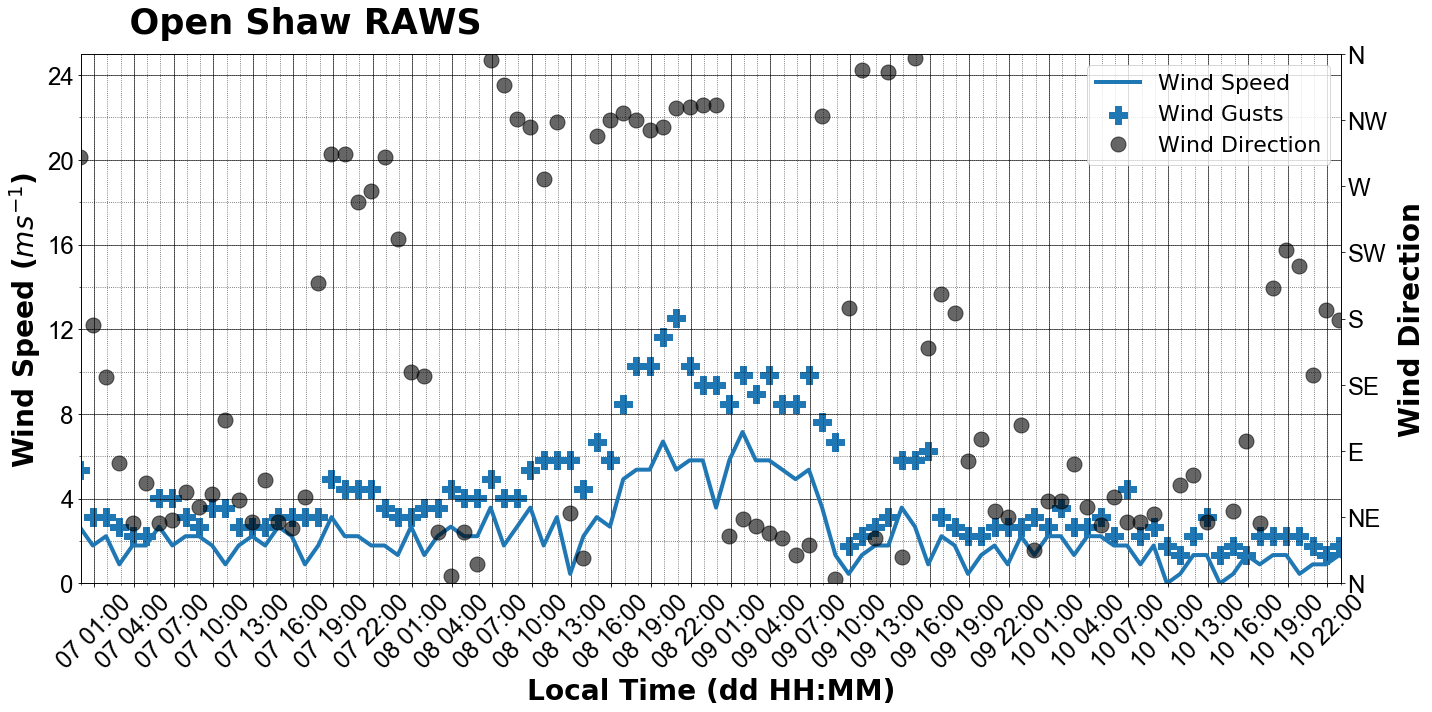

In [97]:
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']
fig= plt.figure(figsize = (20,10))
#fig.suptitle('Jarbo Gap RAWS', fontsize = 40)
"""ax = fig.add_subplot(211)
ax.plot(dfJBGC1.temp, color = 'red', label = 'Air Temperature', linewidth = 4)
ax.set_ylabel('Temp ($\degree$C)', fontsize = 30, fontweight = 'bold')
ax.set_xlabel('Time (Day/Hour)', fontsize = 30, fontweight = 'bold')
ax.set_ylim(5,30)

###
ax1 = ax.twinx()
ax1.plot(dfJBGC1.rh, linestyle = '-', label = 'RH', linewidth = 4)
ax1.set_ylabel('RH (%)', fontsize = 30, fontweight = 'bold')
ax1.set_ylim(0,100)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=0, fontsize = 30)


for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20);
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    


plt.gca().set_xlim(pd.Timestamp('11/07/2018 00:00:00'), pd.Timestamp('11/10/2018 23:00:00'))
#ax.xaxis.set_major_locator(dates.DayLocator(interval=1))# every day
ax.xaxis.set_major_locator(dates.HourLocator(interval=3))# every day
ax.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n%H'))

ax.grid()
ax.grid(which = 'minor', alpha = .7, ls = ':')
ax.set_title('Temperature and RH', fontsize = 35, fontweight = 'bold')"""
####################################################################################################

ax2 = fig.add_subplot(111)
ax2.plot(dfCICC1.wspd, linewidth = 4, label = 'Wind Speed')
ax2.scatter(dfCICC1.index, dfCICC1.wgst, marker = 'P', s =350, label = 'Wind Gusts')
ax2.set_ylabel('Wind Speed ($ms^{-1}$)', fontsize = 28, fontweight = 'bold')
ax2.set_xlabel('Local Time (dd HH:MM)', fontsize = 28, fontweight = 'bold')
ax2.set_ylim(0,25)
ax2.grid(color = 'k', alpha = .7)
plt.xticks(rotation=45)
ax3= ax2.twinx()
ax3.plot(dfCICC1.wdir, 'k.', markersize = 30, alpha = .6, label = 'Wind Direction')
ax3.set_ylim(0,360)
ax3.set_ylabel('Wind Direction', fontsize = 28, fontweight = 'bold', labelpad = 10)
ax3.set_yticklabels(["",'N',"NE", "E", "SE", "S", "SW", "W", "NW", "N"])
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + labels2, loc=1, fontsize = 22)


for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(24);
for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(24)
    


plt.gca().set_xlim(pd.Timestamp('11/01/2018 00:00:00'), pd.Timestamp('11/10/2018 23:00:00'))
#ax2.xaxis.set_major_locator(dates.DayLocator(interval=1))
ticks = ax2.xaxis.set_major_locator(dates.HourLocator(interval=3))
ax2.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base = 4))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(base = 2))
ax2.xaxis.set_major_formatter(dates.DateFormatter('%d %H:%M'))
ax3.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=45.0))
plt.xticks(rotation=30)
ax2.grid(which = 'minor',color = 'k', alpha = .7, ls = ':')
ax2.set_title('    Open Shaw RAWS',loc = 'left', fontsize = 35, fontweight = 'bold', pad = 20.5)
plt.tight_layout()
plt.savefig('OS_raws.png', dpi=fig.dpi)    

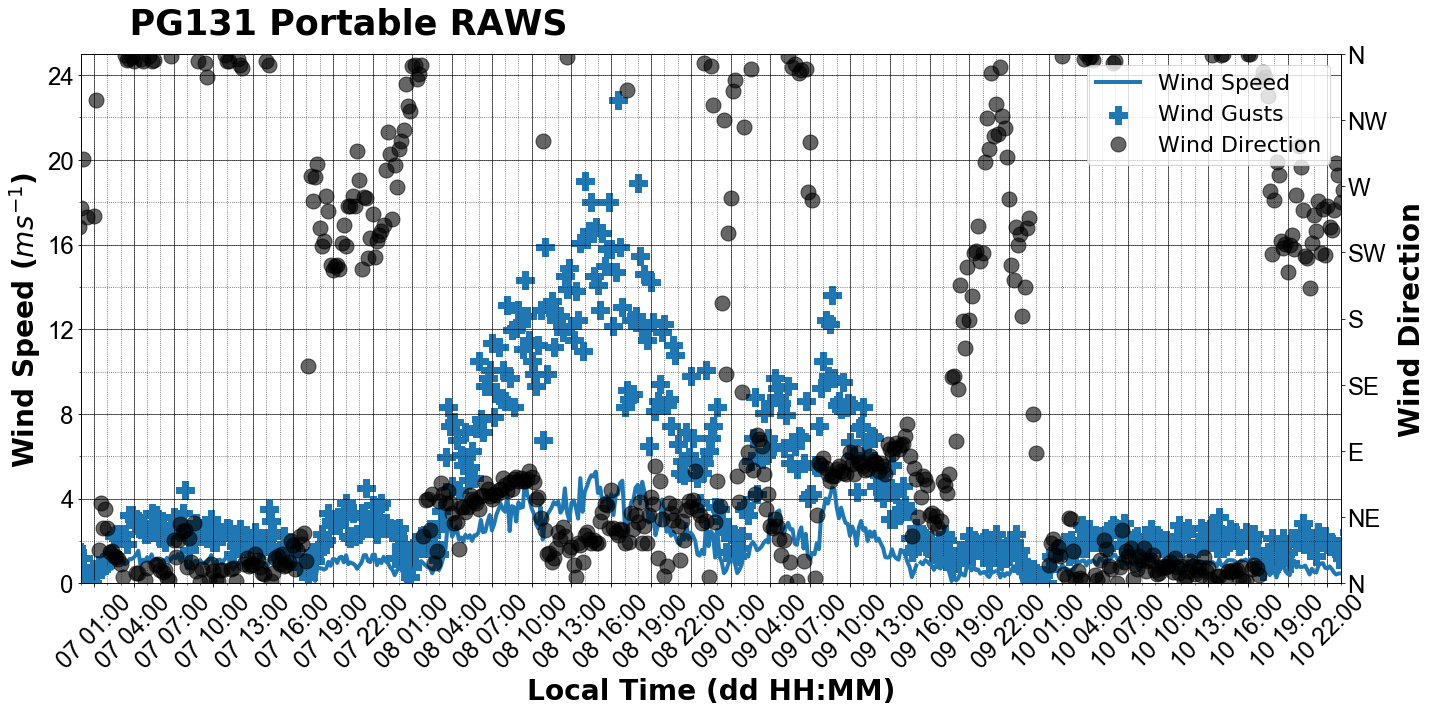

In [94]:
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']
fig= plt.figure(figsize = (20,10))
#fig.suptitle('Jarbo Gap RAWS', fontsize = 40)
"""ax = fig.add_subplot(211)
ax.plot(dfJBGC1.temp, color = 'red', label = 'Air Temperature', linewidth = 4)
ax.set_ylabel('Temp ($\degree$C)', fontsize = 30, fontweight = 'bold')
ax.set_xlabel('Time (Day/Hour)', fontsize = 30, fontweight = 'bold')
ax.set_ylim(5,30)

###
ax1 = ax.twinx()
ax1.plot(dfJBGC1.rh, linestyle = '-', label = 'RH', linewidth = 4)
ax1.set_ylabel('RH (%)', fontsize = 30, fontweight = 'bold')
ax1.set_ylim(0,100)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=0, fontsize = 30)


for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20);
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    


plt.gca().set_xlim(pd.Timestamp('11/07/2018 00:00:00'), pd.Timestamp('11/10/2018 23:00:00'))
#ax.xaxis.set_major_locator(dates.DayLocator(interval=1))# every day
ax.xaxis.set_major_locator(dates.HourLocator(interval=3))# every day
ax.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n%H'))

ax.grid()
ax.grid(which = 'minor', alpha = .7, ls = ':')
ax.set_title('Temperature and RH', fontsize = 35, fontweight = 'bold')"""
####################################################################################################

ax2 = fig.add_subplot(111)
ax2.plot(dfPG131.wspd, linewidth = 4, label = 'Wind Speed')
ax2.scatter(dfPG131.index, dfPG131.wgst, marker = 'P', s =350, label = 'Wind Gusts')
ax2.set_ylabel('Wind Speed ($ms^{-1}$)', fontsize = 28, fontweight = 'bold')
ax2.set_xlabel('Local Time (dd HH:MM)', fontsize = 28, fontweight = 'bold')
ax2.set_ylim(0,25)
ax2.grid(color = 'k', alpha = .7)
plt.xticks(rotation=45)
ax3= ax2.twinx()
ax3.plot(dfPG131.wdir, 'k.', markersize = 30, alpha = .6, label = 'Wind Direction')
ax3.set_ylim(0,360)
ax3.set_ylabel('Wind Direction', fontsize = 28, fontweight = 'bold', labelpad = 10)
ax3.set_yticklabels(["",'N',"NE", "E", "SE", "S", "SW", "W", "NW", "N"])
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + labels2, loc=1, fontsize = 22)


for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(24);
for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(24)
    


plt.gca().set_xlim(pd.Timestamp('11/07/2018 00:00:00'), pd.Timestamp('11/10/2018 23:00:00'))
#ax2.xaxis.set_major_locator(dates.DayLocator(interval=1))
ticks = ax2.xaxis.set_major_locator(dates.HourLocator(interval=3))
ax2.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base = 4))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(base = 2))
ax2.xaxis.set_major_formatter(dates.DateFormatter('%d %H:%M'))
ax3.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=45.0))
plt.xticks(rotation=30)
ax2.grid(which = 'minor',color = 'k', alpha = .7, ls = ':')
ax2.set_title('    PG131 Portable RAWS',loc = 'left', fontsize = 35, fontweight = 'bold', pad = 20.5)
plt.tight_layout()
#plt.savefig('TR_raws.png', dpi=fig.dpi)    

In [ ]:
fig = plt.figure(figsize = (25,10))

ax2 = plt.subplot(111)


ax2.plot(jg_fwi, label = 'Jargo Gap FWI', color = 'tab:red', linewidth =3)
ax2.plot(cc_fwi, label = 'Open Shaw FWI' , color = 'tab:blue',ls = '--', linewidth = 3)
ax2.plot(tr_fwi, label = 'Open Shaw FWI' , color = 'tab:green',ls = ':', linewidth = 3)

ax2.set_xlim(pd.Timestamp('10/15/2018 00:00:00'), pd.Timestamp('11/09/2018 23:00:00'))
ax2.xaxis.set_major_locator(dates.DayLocator(interval=1))    # every day
ax2.xaxis.set_major_formatter(dates.DateFormatter('%m/%d \n %Hz'));
ax2.set_title('Foseburg Fire Weather Index', fontsize = 30)
ax2.set_xlabel('Time (UTC)', fontsize = 25)
ax2.set_ylabel('FWI index', fontsize = 25)
ax2.legend(loc = 2,fontsize = 'xx-large')
#ax.set_ylim(0,15)
ax2.grid()

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(18);
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(18);
#plt.savefig('hdw_fwi.png', dpi=fig.dpi)    